# Changes:
1. Use updated data augumentation functions.
2. Use ReduceLROnPlateau scheduler
3. Fine tune based on previous version trained with 150 epochs.

## Install required packages if running on google colab

In [0]:
try:
    import torch
except:
    !pip install torch torchvision
    !pip install imageio
    !pip install Augmentor
    !git clone https://github.com/allen-q/salt_oil.git
    !git clone https://github.com/allen-q/salt_net.git

In [0]:
cd ../salt_oil

## Import required libs

In [0]:
import zipfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import os
import imageio
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time
import math
import datetime as dt
import pytz
import pickle
from salt_func_lib import *
from torchvision import transforms, utils
from skimage import io, transform
import datetime as dt
import sys
from optparse import OptionParser
import torch.backends.cudnn as cudnn
from torch import optim
from torch.optim import lr_scheduler
import copy
from io import BytesIO
import Augmentor
from Augmentor.Operations import *
from Augmentor import *
import random
import PIL
import cv2 as cv
% matplotlib inline
% load_ext autoreload
% autoreload 2

## Load Unet Modules

In [0]:
from pytorch_unet.eval import eval_net
from pytorch_unet.unet import UNet
from pytorch_unet.unet.unet_parts import *
from pytorch_unet.unet.resnet import *
from pytorch_unet.utils import get_ids, split_ids, split_train_val, get_imgs_and_masks, batch

In [0]:
## Setup data type based on whether GPU is enabled

In [0]:
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!
else:    
    dtype = torch.FloatTensor

In [0]:
print(f'Data Type set to: {dtype}')

## Create Global Variables

In [0]:
def init_global_variables():
    """initialize global variables such as db connection, logger etc."""
    global log
    log = get_logger('SaltNet')

In [0]:
init_global_variables()

In [0]:
def adjust_brightness(img, alpha=None, beta=None):
    if alpha is None:
        # get a random num from 0.75 to 1.25
        alpha = (random.random()/2)+0.75
    if beta is None:
        # get a random num from -30 to 30
        beta = round((random.random()-0.5)*60)
    #print(f'a:{alpha}, b:{beta}')
    img_new = cv.convertScaleAbs(img, alpha=alpha, beta=beta)
    return img_new.reshape(img.shape)

In [0]:
class SaltDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, np_img, np_mask, df_depth, mean_img, out_size=101, 
                 out_ch=1, transform=None, random_brightness=0):
        """
        Args:
            data_dir (string): Path to the image files.
            train (bool): Load train or test data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.np_img = np_img
        self.np_mask = np_mask.clip(0,1)
        self.df_depth = df_depth
        self.mean_img = mean_img
        self.out_size = out_size
        self.out_ch = out_ch
        self.transform = transform
        self.random_brightness = random_brightness

    def __len__(self):
        return len(self.np_img)

    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.item()
            
        X = self.np_img[idx]
        #X = X - self.mean_img

        if self.np_mask is None:
            y = np.zeros((101,101,1))
        else:
            y = self.np_mask[idx]

        if self.transform:
            img_in = PIL.Image.fromarray(np.c_[np.tile(X, 2), y*255])
            #img_in = PIL.Image.fromarray(np.tile(y, 3)*255)
            transformed = np.array(self.transform(img_in))
            #X = np.clip(transformed[:,:,0:1]/255, 0., 1.) - self.mean_img
            X = transformed[:,:,0:1]
            y = np.clip(transformed[:,:,2:3]/255, 0., 1.)
            
        if self.random_brightness > random.random():            
            X = adjust_brightness(X)
            X = np.clip(X/255, 0., 1.) - self.mean_img
        else:
            X = np.clip(X/255, 0., 1.) - self.mean_img            
        #from boxx import g
        #g()
        X = np.moveaxis(X, -1,0)

        pad_size = self.out_size - X.shape[2]
        pad_first = pad_size//2
        pad_last = pad_size - pad_first
        X = np.pad(X, [(0, 0),(pad_first, pad_last), (pad_first, pad_last)], mode='reflect')

        d = self.df_depth.iloc[idx,0]

        X = torch.from_numpy(X).float().type(dtype)
        X = X.repeat(self.out_ch,1,1)
        y = transform.resize(y, (101, 101), mode='constant', preserve_range=True)
        y = torch.from_numpy(y).ge(0.5).float().squeeze().type(dtype)

        return (X,y,d,idx)

In [0]:
class Pipeline_Salt(Augmentor.Pipeline):
    def __init__(self, source_directory=None, output_directory="output", save_format=None):
        super(Pipeline_Salt, self).__init__(source_directory, output_directory, save_format)

    def torch_transform(self):
        def _transform(image):
            for operation in self.operations:
                r = round(random.uniform(0, 1), 1)
                if r <= operation.probability:
                    if not isinstance(image, list):
                        image = [image]                        
                    #print(type(operation))
                    #print(np.array(image[0]).shape)                        
                    image = operation.perform_operation(image)[0]

            return image

            
        return _transform
    
    def crop_random_align(self, probability, min_factor, max_factor, mask_diff_pct, resample_filter="BICUBIC"):     
        if not 0 < probability <= 1:
            raise ValueError(Pipeline._probability_error_text)
        elif not (min_factor>0) and (min_factor<=1):
            raise ValueError("min_factor must be between 0 and 1.")
        elif not (max_factor>0) and (min_factor<=1):
            raise ValueError("max_factor must be between 0 and 1.")
        elif resample_filter not in Pipeline._legal_filters:
            raise ValueError("The save_filter argument must be one of %s." % Pipeline._legal_filters)
        else:
            self.add_operation(CropRandomAlign(probability, min_factor, max_factor, mask_diff_pct, resample_filter))
            
    def resize_random(self, probability, min_factor, max_factor, resample_filter="BICUBIC"):
        if not 0 < probability <= 1:
            raise ValueError(Pipeline._probability_error_text)
        elif resample_filter not in Pipeline._legal_filters:
            raise ValueError("The save_filter argument must be one of %s." % Pipeline._legal_filters)
        else:
            self.add_operation(ResizeRandom(probability=probability, min_factor=min_factor,
                                            max_factor=max_factor, resample_filter=resample_filter))

In [0]:
class ResizeRandom(Operation):
    """
    This class is used to resize an image by a random factor between min_factor and max_factor.
    """
    def __init__(self, probability, min_factor, max_factor, resample_filter="BICUBIC"):
        Operation.__init__(self, probability)
        self.min_factor = min_factor
        self.max_factor = max_factor
        self.resample_filter = resample_filter

    def perform_operation(self, images):
        """
        Resize the passed image and returns the resized image. Uses the
        parameters passed to the constructor to resize the passed image.

        :param images: The image to resize.
        :type images: List containing PIL.Image object(s).
        :return: The transformed image(s) as a list of object(s) of type
         PIL.Image.
        """

        def do(image):
            width, height = image.size
            resize_factor = random.randrange(round(self.min_factor*100), round(self.max_factor*100), 1)/100
            width = round(width*resize_factor) 
            height = round(height*resize_factor) 
            print(f'New Width: {width}, New Height: {height}')
            return image.resize((width, height), eval("Image.%s" % self.resample_filter))

        augmented_images = []

        for image in images:
            augmented_images.append(do(image))

        return augmented_images

In [0]:
class CropRandomAlign(Operation):
    """
    This class is used to crop images a random factor between min_factor and max_factor and resize it to its original size.
    """
    def __init__(self, probability, min_factor, max_factor, mask_diff_pct, resample_filter="BICUBIC"):
        Operation.__init__(self, probability)
        self.min_factor = min_factor
        self.max_factor = max_factor
        self.mask_diff_pct = mask_diff_pct
        self.resample_filter = resample_filter

    def perform_operation(self, images):
        """
        Crop the passed :attr:`images` by percentage area, returning the crop as an
        image.

        :param images: The image(s) to crop an area from.
        :type images: List containing PIL.Image object(s).
        :return: The transformed image(s) as a list of object(s) of type
         PIL.Image.
        """

        resize_factor = random.randrange(round(self.min_factor*100), round(self.max_factor*100), 1)/100

        # The images must be of identical size, which is checked by Pipeline.ground_truth().
        w, h = images[0].size

        w_new = int(floor(w * resize_factor))  # TODO: Floor might return 0, so we need to check this.
        h_new = int(floor(h * resize_factor))

        def do(image, w, h):
            img_np = np.array(image)
            mask_in = img_np[:,:,2]
            mask_in_pct = (mask_in>0).sum()/mask_in.size
            img_out_candidate = None
            lowest_diff = 1
            for i in range(20):  
                left_shift = random.randint(0, int((w - w_new)))
                down_shift = random.randint(0, int((h - h_new)))
                img_out = image.crop((left_shift, down_shift, w_new + left_shift, h_new + down_shift))
                mask_out = np.array(img_out)[:,:,2]
                mask_out_pct = (mask_out>0).sum()/mask_out.size
                #print(f'mask_in_pct:{mask_in_pct}, mask_out_pct:{mask_out_pct}')
                if (mask_in_pct==0) or (abs((mask_out_pct/mask_in_pct)-1) <= self.mask_diff_pct):                    
                    img_out_candidate = img_out
                    break
                if (abs((mask_out_pct/mask_in_pct)-1)) <= lowest_diff:
                    lowest_diff = abs((mask_out_pct/mask_in_pct)-1)
                    img_out_candidate = img_out
            if img_out_candidate is None:
                img_out_candidate = image
                print('Failed to crop image to fit requirements. Use orignal image.')
            #print(f'Image Size after crop:{img_out_candidate.size}')
            mask_out = np.array(img_out_candidate)[:,:,2]
            #print(f'image mask pct:{(mask_out>0).sum()/mask_out.size}')
            img_out_final = img_out_candidate.resize((w, h), eval("Image.%s" % self.resample_filter))
            #print(f'Image Size after resize:{img_out_final.size}')            
            
            return img_out_final
            
        augmented_images = []

        for image in images:
            augmented_images.append(do(image, w, h))

        return augmented_images

In [0]:
'''p = Pipeline_Salt()

p.crop_random_align(1, 0.3, 0.5, 0.01)

p.resize_random(probability=1,min_factor=1.1, max_factor=2.5, resample_filter='BILINEAR')

img = np.c_[np.tile(X_train[1507], 2), y_train[1507]]

plt.imshow(img[:,:,2], cmap='gray')

img_in = PIL.Image.fromarray(img)
tsfm = p.torch_transform()
img_out = tsfm(img_in)

np.array(img_out).shape

plt.imshow(np.array(img_out)[:,:,2], cmap='gray')'''

## Prepare Data

### Load train and test data from npy files or from raw images if npy files not exist.

In [0]:
np_train_all, np_train_all_mask, X_test, misc_data = load_all_data()

### Calculate number of mask pixels per image

In [0]:
df_train_mask = pd.DataFrame((np_train_all_mask/255).sum((1,2,3)), columns=['mask_pix'])

df_train_mask.mask_pix = df_train_mask.mask_pix.round(-2)

mask_pix_bins = df_train_mask.mask_pix.sort_values().unique()
# Due to zooming and crop, under-sample all black and all white masks, over-sample images with small mask areas.
mask_pix_bin_weights = ([1.] + np.r_[2:1:102j].tolist() + [0.2])
mask_pix_bin_weights = dict(zip(mask_pix_bins, mask_pix_bin_weights))

train_all_sample_weight = df_train_mask.mask_pix.map(mask_pix_bin_weights)

In [0]:
df_train_mask.shape

### Remove black images

In [0]:
#black_img_ids = (np_train_all.max((1,2,3))==0)

#np_train_all = np_train_all[~black_img_ids]
#np_train_all_mask = np_train_all_mask[~black_img_ids]

In [0]:
np_train_all.shape

### Remove images with all black masks

In [0]:
#black_mask_ids = (np_train_all_mask.max((1,2,3))==0)
#np_train_all = np_train_all[~black_mask_ids]
#np_train_all_mask = np_train_all_mask[~black_mask_ids]

### Train Val data split

In [0]:
#np_train_all = np.clip(np_train_all/255, 0, 1)
#X_test = np.clip(X_test/255, 0, 1)

In [0]:
X_train_ids, X_val_ids = (
    train_test_split(df_train_mask.index.tolist(), 
                     test_size=0.20,
                     stratify = df_train_mask.mask_pix,
                     random_state=0)
)

In [0]:
with open('./data/df_train_img_iou.pickle', 'rb') as f:
    df_train_img_iou = pickle.load(f)

train_hard_img_id= (
    [misc_data['np_train_all_ids'].index(e) for e in df_train_img_iou.loc[df_train_img_iou.type=='HARD'].id]
)

#X_train_ids = np.setdiff1d(X_train_ids, train_hard_img_id)

In [0]:
X_train = np_train_all[X_train_ids]
X_val = np_train_all[X_val_ids]
y_train = np_train_all_mask[X_train_ids]
y_val = np_train_all_mask[X_val_ids]
depth_train = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_train_ids])
)
depth_val = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_val_ids])
)
depth_test = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_test_ids']))
)
#X_train_mean_img = X_train.mean(0).astype(np.float32)
#X_train_mean_img = X_train.mean((0,1,2)).astype(np.float32)
X_train_mean_img = np.clip(np_train_all/255, 0, 1).mean((0,1,2)).astype(np.float32)

all_data = {
    'X_train': X_train,
    'X_val': X_val,
    'y_train': y_train,
    'y_val': y_val,
    'X_test': X_test,
    'X_train_mean_img': np.zeros_like(X_train_mean_img)
}

In [0]:
train_sample_weight = train_all_sample_weight[X_train_ids]

In [0]:
train_sample_weight.head()

In [0]:
misc_data['np_train_all_ids'].index('999cb0ea3b')

In [0]:
depth_train

In [0]:
X_train_mean_img = np.zeros_like(X_train_mean_img)

In [0]:
X_train_mean_img

In [0]:
X_train.shape

In [0]:
y_train.shape

In [0]:
depth_train.shape

In [0]:
'''p = Pipeline_Salt(min_mask_ratio=0.9)
p.crop_random(probability=1, percentage_area=0.8, randomise_percentage_area=False)
p.resize(probability=1, width=101, height=101, resample_filter='BILINEAR')
img = np.c_[np.tile(X_train[469], 2), y_train[469]]
img_in = PIL.Image.fromarray(img)
tsfm = p.torch_transform()
img_out = tsfm(img_in)'''

In [0]:
p = Pipeline_Salt()
p.skew(probability=0.5, magnitude=0.2)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.crop_random_align(probability=0.5, min_factor=0.5, max_factor=0.95, mask_diff_pct=0.2)
p.rotate(probability=0.5, max_left_rotation=5, max_right_rotation=5)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)

### Create a Train Dataloader

In [0]:
#weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_sample_weight.values, depth_train.shape[0])

train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': True}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           X_train_mean_img, out_size=128,  out_ch=1,
                           transform=p.torch_transform(), random_brightness=0.5), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           X_train_mean_img, out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

sample = iter(dataloaders['train']).__next__()

assert sample[0].shape == torch.Size([train_data_params['batch_size'], 1, 128, 128])
assert sample[1].shape == torch.Size([train_data_params['batch_size'], 101, 101])
assert sample[2].shape == torch.Size([train_data_params['batch_size']])
assert sample[3].shape == torch.Size([train_data_params['batch_size']])

In [0]:
t = iter(train_dataLoader).__next__()

In [0]:
X_batch, y_batch, d_batch, X_id = t

In [0]:
i = 0
for X_batch, y_batch, d_batch, X_id in dataloaders['train']:
    i+=1
    if i>30:
        break
    X_orig = X_train[X_id[0]].squeeze()/255
    X_tsfm = X_batch[0,0].squeeze().cpu().detach().numpy()[13:114,13:114] + X_train_mean_img.squeeze()
    y_orig = y_train[X_id[0]].squeeze()
    y_tsfm = (y_batch[0].squeeze().cpu().detach().numpy())
    print(f'{X_orig.sum()}, {X_tsfm.sum()}')
    plot_img_mask_pred([X_orig, X_tsfm, y_orig, y_tsfm],
                       [f'X Original-{X_id[0]}', 'X Transformed', 'y Original', 'y Transformed'])

### Create a Train Dataloader for sanity check

In [0]:

#weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(depth_train['weight'][:8], 2)#weight 
#weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_sample_weight.values[:8], 2)
train_data_params = {'batch_size': 2, 'shuffle': True,}
val_data_params = {'batch_size': 2, 'shuffle': True,}

In [0]:

train_dataLoader  = (
    DataLoader(SaltDataset(X_train[:4], y_train[:4], depth_train[:4],
                           X_train_mean_img, out_size=128, out_ch=1,
                           transform=None), **train_data_params)
                           #transform=p.torch_transform()), **data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val[:4], y_val[:4], depth_val[:4], 
                           X_train_mean_img, out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}


In [0]:
t = iter(train_dataLoader).__next__()

In [0]:
X_batch, y_batch, d_batch, X_id = t

In [0]:
X_batch[0].max()

In [0]:
def log_iter_stats(y_pred, y_batch, X_batch, X_id, train_params, other_data, epoch_losses, epoch, iter_count, start):
    #from boxx import g
    #g(), 
    epoch_losses = [round(e.item(),4) for e in torch.stack(epoch_losses).mean(0)]
    iou_batch = calc_mean_iou(y_pred.ge(train_params['mask_cutoff']), y_batch)
    iou_acc = calc_clf_accuracy(y_pred.ge(train_params['mask_cutoff']), y_batch)

    log.info('Losses: {}, Batch IOU: {:.4f}, Batch Acc: {:.4f} at iter {}, epoch {}, Time: {}'.format(
            epoch_losses, iou_batch, iou_acc, iter_count, epoch, timeSince(start))
    )

    X_train = other_data['X_train']
    y_train = other_data['y_train']
    X_train_mean_img = other_data['X_train_mean_img']
    #print(all_losses)
    X_orig = X_train[X_id[0]].squeeze()/255
    X_tsfm = X_batch[0,0].squeeze().cpu().detach().numpy()
    X_tsfm = X_tsfm[13:114,13:114] + X_train_mean_img.squeeze()
    y_orig = y_train[X_id[0]].squeeze()
    y_tsfm = (y_batch[0].squeeze().cpu().detach().numpy())
    y_tsfm_pred =  y_pred[0].squeeze().gt(train_params['mask_cutoff'])
    plot_img_mask_pred([X_orig, X_tsfm, y_orig, y_tsfm, y_tsfm_pred],
                       ['X Original', 'X Transformed', 'y Original', 'y Transformed', 'y Predicted'])

In [0]:
def log_epoch_stats(model, y_pred, y_batch, X_batch, X_id, other_data, pred_vs_true_epoch, train_params, phase, epoch, iter_count, best_iou, all_losses, epoch_losses, best_model):    
    y_pred_epoch = torch.cat([e[0] for e in pred_vs_true_epoch])
    y_true_epoch = torch.cat([e[1] for e in pred_vs_true_epoch])

    mean_iou_epoch = calc_mean_iou(y_pred_epoch.ge(train_params['mask_cutoff']), y_true_epoch.float())
    mean_acc_epoch = calc_clf_accuracy(y_pred_epoch.ge(train_params['mask_cutoff']), y_true_epoch.float())
    mean_loss_epoch = [round(e.item(),4) for e in torch.stack(epoch_losses).mean(0)]

    if phase == 'val':        
        X_val = other_data['X_val']
        y_val = other_data['y_val']
        X_orig = X_val[X_id[0]].squeeze()/255
        y_orig = y_val[X_id[0]].squeeze()
        y_pred2 =  y_pred[0].squeeze().gt(train_params['mask_cutoff'])
        plot_img_mask_pred([X_orig, y_orig, y_pred2],
                           ['Val X Original', 'Val y Original', 'Val y Predicted'])
        if mean_iou_epoch > best_iou:
            best_iou = mean_iou_epoch
            stats = {'best_iou': best_iou,
                   'all_losses': all_losses,
                   'iter_count': iter_count}
            best_model = (epoch, copy.deepcopy(model.state_dict()),
                                              copy.deepcopy(optimizer.state_dict()),
                                              copy.deepcopy(scheduler.state_dict()), stats, train_params['model_save_name'], '.')
            log.info(save_model_state_to_chunks(*best_model))
            log.info('Best Val Mean IOU so far: {}'.format(best_iou))        
        log.info('Val   IOU: {:.4f}, Acc: {:.4f}, Best Val IOU: {:.4f} at epoch {}'.format(mean_iou_epoch, mean_acc_epoch, best_iou, epoch))
    else:
        log.info('Train IOU: {:.4f}, Acc: {:.4f}, Loss: {} at epoch {}'.format(mean_iou_epoch, mean_acc_epoch, mean_loss_epoch, epoch))
        X_train = other_data['X_train']
        y_train = other_data['y_train']
        X_train_mean_img = other_data['X_train_mean_img']
        X_orig = X_train[X_id[0]].squeeze()/255
        X_tsfm = X_batch[0,0].squeeze().cpu().detach().numpy()
        X_tsfm = X_tsfm[13:114,13:114] + X_train_mean_img.squeeze()
        y_orig = y_train[X_id[0]].squeeze()
        y_tsfm = (y_batch[0].squeeze().cpu().detach().numpy())
        y_tsfm_pred =  y_pred[0].squeeze().gt(train_params['mask_cutoff'])
        plot_img_mask_pred([X_orig, X_tsfm, y_orig, y_tsfm, y_tsfm_pred],
                           ['X Original', 'X Transformed', 'y Original', 'y Transformed', 'y Predicted'])
        
    return best_iou, best_model

In [0]:
def save_model_to_git(epoch, train_params, num_epochs, prev_best_iou, best_iou, best_model):    
    if (epoch % train_params['save_model_every']== 0) | (epoch == num_epochs-1):
        if train_params['model_save_name'] is None:
            log.info("Skip pushing model to git as model_save_name is None.")
        elif (best_model is not None) and (best_iou > prev_best_iou):
            log.info(save_model_state_to_chunks(*best_model))
            push_model_to_git(ckp_name=train_params['model_save_name'])
            prev_best_iou = best_iou
        else:
            log.info("Skip pushing model to git as there's no improvement")
            
    return prev_best_iou

In [0]:
def calc_loss(y_pred, y_batch, loss_fns, loss_fn_weights):
     losses = []
     for loss_fn, loss_fn_weight in zip(loss_fns, loss_fn_weights):
         loss = loss_fn_weight * loss_fn(y_pred, y_batch)
         losses.append(loss)  

     return torch.stack(losses + [torch.stack(losses).sum()])

In [0]:
def train_model(model, dataloaders, loss_fns, loss_fn_weights, optimizer, scheduler, train_params, other_data):
    log.info('Start Training...')    
    log.info((dataloaders, loss_fns, loss_fn_weights, optimizer, scheduler, train_params))
    num_epochs = train_params['num_epochs']
    start = time.time()
    if torch.cuda.is_available():
        model.cuda()
    best_model = None
    best_iou = 0.0    
    prev_best_iou = train_params['model_save_iou_threshold']
    all_losses = []
    iter_count = 0

    for epoch in range(1, num_epochs+1):
        log.info('Epoch {}/{}'.format(epoch, num_epochs))
        log.info('-' * 20)
        if (epoch % train_params['save_log_every'] == 0):
            push_log_to_git()
        epoch_losses = []
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()      
            pred_vs_true_epoch = []
            for X_batch, y_batch, d_batch, X_id in dataloaders[phase]:
                # zero the parameter gradients
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    y_pred = model(X_batch)
                    pred_vs_true_epoch.append([y_pred, y_batch])
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        losses = calc_loss(y_pred, y_batch.float(), loss_fns, loss_fn_weights)
                        epoch_losses.append(losses)
                        all_losses.append(losses)
                        loss = losses[-1]
                        loss.backward()
                        optimizer.step()
                        iter_count += 1
            best_iou, best_model = log_epoch_stats(model, y_pred, y_batch, X_batch, X_id, other_data, pred_vs_true_epoch, train_params, 
                                                   phase, epoch, iter_count, best_iou, all_losses, epoch_losses, best_model)
            
        prev_best_iou = save_model_to_git(epoch, train_params, num_epochs, prev_best_iou, best_iou, best_model)
        #from boxx import g
        #g()
        epoch_avg_loss = np.mean([e[-1].item() for e in epoch_losses])
        #log.info(f'scheduler best: {scheduler.best} num_bad_epochs:{scheduler.num_bad_epochs}')
        log.info(scheduler.step(epoch))


    # load best model weights
    model.load_state_dict(best_model[1])
    log.info('-' * 20)
    log.info(f'Training complete in {(time.time() - start) // 60} mins. Best Val IOU {round(best_iou, 4)}')

    return model

## Train the model using a small data set to see if it can overfit

In [0]:
#saltnet = resnet34unet(in_ch=3, bilinear=False, pretrained=False)
saltnet = UResNet(pretrained=True)

loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()

optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)

#scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True, threshold=0.001)
model_save_name = None

# Test Run
#trained_model = train_model(saltnet, dataloaders, loss_fn_bce, loss_lovasz_hinge, optimizer, scheduler, model_save_name, 
#                other_data=all_data, num_epochs=100, print_every=8, save_model_every=None, save_log_every=None, log=log, loss2_weight=0.0)

In [0]:
train_params = {
    'model_save_name': None,
    'save_model_every': 10000,
    'save_log_every': 100,
    'num_epochs': 10,
    'print_every': 2,
    'log': log,
    'mask_cutoff': 0,
    'model_save_iou_threshold': 0.1
    }

In [0]:
scheduler.num_bad_epochs

In [0]:
model = train_model(saltnet, dataloaders, (loss_fn_bce, loss_lovasz_hinge), (1, 0.5), optimizer, scheduler, train_params, all_data)

## Train the full with full dataset

In [0]:
log.info('Use Unet with Resnet 34 as backbone with Adam and updated data aug class')

In [0]:
model_config = '''
p = Pipeline_Salt()
p.skew(probability=0.5, magnitude=0.2)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.crop_random_align(probability=0.5, min_factor=0.5, max_factor=0.9, mask_diff_pct=0.2)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)

train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': False}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform(), random_brightness=0.5), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           np.zeros_like(X_train_mean_img), out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}


#saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True, apply_se=True, r=16)
saltnet = UResNet(pretrained=True)
loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, min_lr=0.00001)

model_save_name = f'../salt_net/Unet_res34_bce_lovasz_loss_se_new_aug_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

train_params = {
    'model_save_name': model_save_name,
    'save_model_every': 20,
    'save_log_every': 2,
    'num_epochs': 150,
    'log': log,
    'mask_cutoff': 0.,
    'model_save_iou_threshold': 0.78
    }
    
train_model(saltnet, dataloaders, (loss_fn_bce, loss_lovasz_hinge), (1, 0.1), optimizer, scheduler, train_params, all_data)

'''

In [0]:
log.info(model_config)

In [0]:
p = Pipeline_Salt()
p.skew(probability=0.5, magnitude=0.2)
p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.crop_random_align(probability=0.5, min_factor=0.5, max_factor=0.9, mask_diff_pct=0.2)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)

train_data_params = {'batch_size': 32,
                     #'sampler': weighted_sampler,
                     'shuffle': True,
                     'drop_last': False}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform(), random_brightness=0.5), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           np.zeros_like(X_train_mean_img), out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

In [0]:
#saltnet = UNet(n_channels=1, n_classes=1, bilinear=True, logits=True, apply_se=True, r=16)
saltnet = UResNet(pretrained=True)
loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
#loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, min_lr=0.00001)

model_save_name = f'../salt_net/Unet_res34_bce_lovasz_loss_se_new_aug_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

In [0]:
train_params = {
    'model_save_name': model_save_name,
    'save_model_every': 20,
    'save_log_every': 2,
    'num_epochs': 150,
    'log': log,
    'mask_cutoff': 0.,
    'model_save_iou_threshold': 0.78
    }


In [0]:
train_model(saltnet, dataloaders, (loss_fn_bce, loss_lovasz_hinge), (1, 0.1), optimizer, scheduler, train_params, all_data)

In [0]:
all_data.keys()

## Fine Tune

### Finetune 4

In [0]:
log.info('Use Unet with Resnet 34 as backbone with Adam and updated data aug class. Finetuning from IOU 0.8248. Over sample hard images.')

In [0]:
model_config = '''
weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_data_weight, len(train_data_weight))#weight 
p = Pipeline_Salt()
#p.skew(probability=0.5, magnitude=0.2)
#p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.crop_random_align(probability=0.5, min_factor=0.5, max_factor=0.9, mask_diff_pct=0.2)
#p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
#p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)

train_data_params = {'batch_size': 32,
                     'sampler': weighted_sampler
                    }
                     #'shuffle': True,
                     #'drop_last': False}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform(), random_brightness=0.5), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           np.zeros_like(X_train_mean_img), out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}


saltnet = UResNet(pretrained=False)
model_file_suffix = "Unet_res34_bce_lovasz_loss_se_weight_decay_finetune10_2018_09_25_17_00_30.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])


optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.0001, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.8)

#loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()

model_save_name = f'../salt_net/Unet_res34_weight_decay_over_sample_finetune15_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

train_model(saltnet, dataloaders, (loss_focal, loss_lovasz_hinge), (1, 0.02), optimizer, scheduler, train_params, all_data)

'''

In [282]:
log.info(model_config)

25/09/2018 12:35:02 - SaltNet - INFO - 
weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_data_weight, len(train_data_weight))#weight 
p = Pipeline_Salt()
#p.skew(probability=0.5, magnitude=0.2)
#p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.crop_random_align(probability=0.5, min_factor=0.5, max_factor=0.9, mask_diff_pct=0.2)
#p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
#p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)

train_data_params = {'batch_size': 32,
                     'sampler': weighted_sampler
                    }
                     #'shuffle': True,
                     #'drop_last': False}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           np.zeros_like(X_train_mean_img)

In [0]:
weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_data_weight, len(train_data_weight))#weight 
p = Pipeline_Salt()
#p.skew(probability=0.5, magnitude=0.2)
#p.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)
p.crop_random_align(probability=0.5, min_factor=0.5, max_factor=0.9, mask_diff_pct=0.2)
#p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
#p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
p.flip_left_right(probability=0.5)

train_data_params = {'batch_size': 32,
                     'sampler': weighted_sampler
                    }
                     #'shuffle': True,
                     #'drop_last': False}

val_data_params = {'batch_size': 32,
                   'shuffle': True,
                   'drop_last': False}

train_dataLoader = (
    DataLoader(SaltDataset(X_train, y_train, depth_train,
                           np.zeros_like(X_train_mean_img), out_size=128,  out_ch=1,
                           transform=p.torch_transform(), random_brightness=0.5), **train_data_params)
)

val_dataLoader = (
    DataLoader(SaltDataset(X_val, y_val, depth_val, 
                           np.zeros_like(X_train_mean_img), out_size=128, out_ch=1), **val_data_params)
)

dataloaders = {'train': train_dataLoader, 'val':val_dataLoader}

In [0]:
X_ids = []

In [0]:
for X_batch, y_batch, d_batch, X_id in dataloaders['train']:
  X_ids.append(X_id)

In [0]:
s = pd.Series(torch.cat(X_ids).detach().numpy())

In [0]:
train_data_weight

In [0]:
train_data_weight[2952]

In [269]:
s.groupby(s).count().sort_values().tail()

700     5
1668    5
1541    5
3168    5
2286    6
dtype: int64

In [270]:
s.nunique()

2019

In [0]:
l2 = torch.tensor(0.).float().cuda()
for p in saltnet.parameters():
  if p.requires_grad:
    l2+=torch.sum(p**2)

In [0]:
l2*0.00001

In [277]:
saltnet = UResNet(pretrained=False)
model_file_suffix = "Unet_res34_bce_lovasz_loss_se_weight_decay_finetune10_2018_09_25_17_00_30.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
saltnet.load_state_dict(model_state_dict['model'])

ResNetnot using pretrained weights.


In [0]:
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.0001, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.8)

In [279]:
#loss_fn_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2.0).type(dtype))
loss_focal = FocalLoss(0.25, 2, logits=True)
loss_lovasz_hinge = LovaszHingeLoss()

#model_save_name = f'../salt_net/Unet_res34_weight_decay_over_sample_finetune15_{get_current_time_as_fname()}.ckp'
log.info(model_save_name)

25/09/2018 12:33:11 - SaltNet - INFO - ../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp


In [0]:
train_params = {
    'model_save_name': model_save_name,
    'save_model_every': 20,
    'save_log_every': 2,
    'num_epochs': 100,
    'log': log,
    'mask_cutoff': 0.,
    'model_save_iou_threshold': 0.83
    }

25/09/2018 12:35:51 - SaltNet - INFO - Start Training...
25/09/2018 12:35:51 - SaltNet - INFO - ({'train': <torch.utils.data.dataloader.DataLoader object at 0x7f6b68b0ecf8>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f6b0bf39198>}, (FocalLoss(), LovaszHingeLoss()), (1, 0.02), Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0001
    lr: 0.0001
    weight_decay: 1e-05
), <torch.optim.lr_scheduler.StepLR object at 0x7f6aa4a8d748>, {'model_save_name': '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp', 'save_model_every': 20, 'save_log_every': 2, 'num_epochs': 100, 'log': <Logger SaltNet (DEBUG)>, 'mask_cutoff': 0.0, 'model_save_iou_threshold': 0.83})
25/09/2018 12:35:51 - SaltNet - INFO - Epoch 1/100
25/09/2018 12:35:51 - SaltNet - INFO - --------------------
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.fun

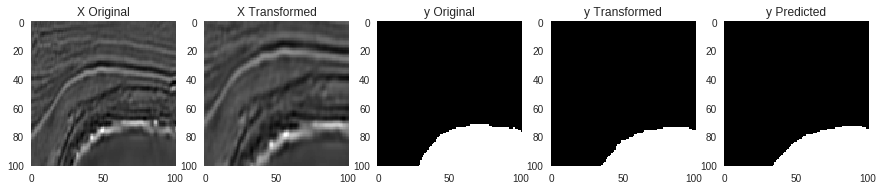

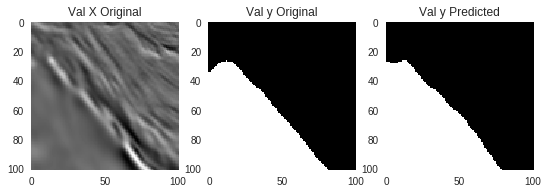

25/09/2018 12:39:27 - SaltNet - INFO - ['../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-1-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-2-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-3-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-4-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-5-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-6-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-7-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-8-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-9-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_

/content/salt_net
From https://github.com/allen-q/salt_net
 * [new branch]      master     -> origin/master
There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=origin/<branch> master

[master 15d0cfa] Pushing logs to git
 1 file changed, 81 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 741 bytes | 741.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   309ebac..15d0cfa  master -> master


25/09/2018 12:43:01 - SaltNet - INFO - Train IOU: 0.6271, Acc: 0.9420, Loss: [0.0094, 0.0119, 0.0213] at epoch 2


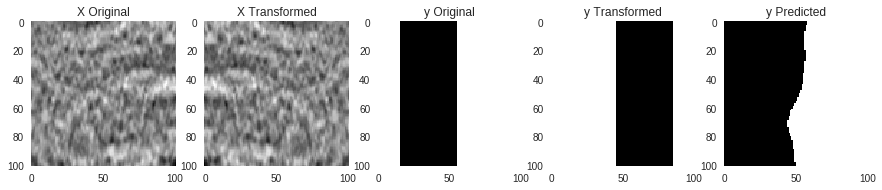

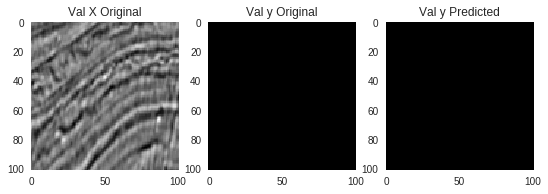

25/09/2018 12:43:19 - SaltNet - INFO - ['../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-1-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-2-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-3-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-4-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-5-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-6-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-7-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-8-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-9-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_

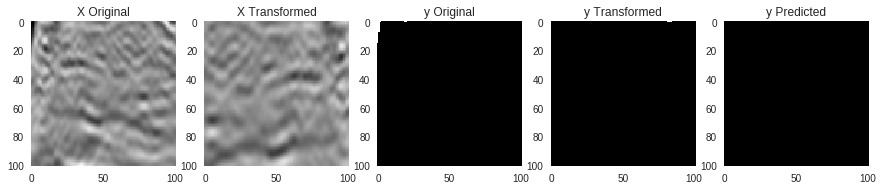

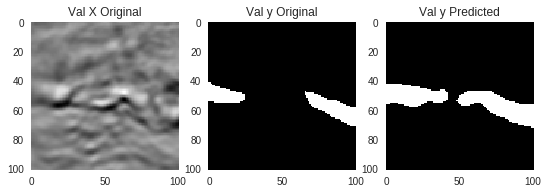

25/09/2018 12:46:53 - SaltNet - INFO - Val   IOU: 0.8069, Acc: 0.9623, Best Val IOU: 0.8071 at epoch 3
25/09/2018 12:46:53 - SaltNet - INFO - None
25/09/2018 12:46:53 - SaltNet - INFO - Epoch 4/100
25/09/2018 12:46:53 - SaltNet - INFO - --------------------
25/09/2018 12:46:53 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
From https://github.com/allen-q/salt_net
   309ebac..15d0cfa  master     -> origin/master
There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=origin/<branch> master

[master c19e66f] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 555 bytes | 555.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   15d0cfa..c19e66f  master -> master


25/09/2018 12:50:32 - SaltNet - INFO - Train IOU: 0.6510, Acc: 0.9491, Loss: [0.0083, 0.0111, 0.0194] at epoch 4


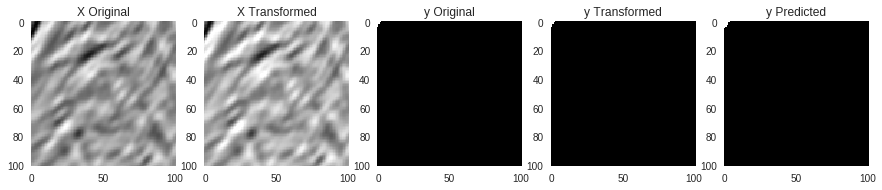

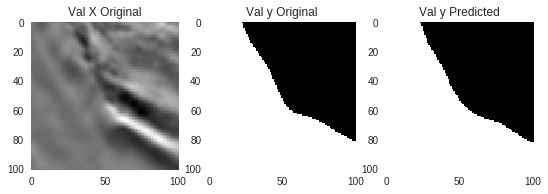

25/09/2018 12:50:47 - SaltNet - INFO - Val   IOU: 0.8069, Acc: 0.9562, Best Val IOU: 0.8071 at epoch 4
25/09/2018 12:50:47 - SaltNet - INFO - None
25/09/2018 12:50:47 - SaltNet - INFO - Epoch 5/100
25/09/2018 12:50:47 - SaltNet - INFO - --------------------
25/09/2018 12:54:06 - SaltNet - INFO - Train IOU: 0.6390, Acc: 0.9503, Loss: [0.0082, 0.0115, 0.0196] at epoch 5


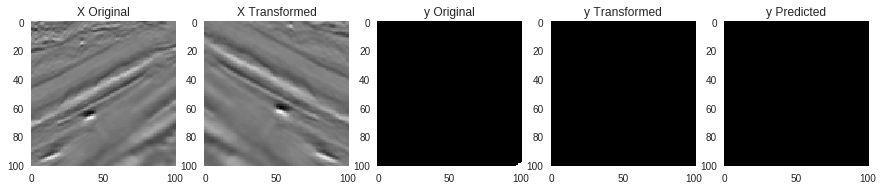

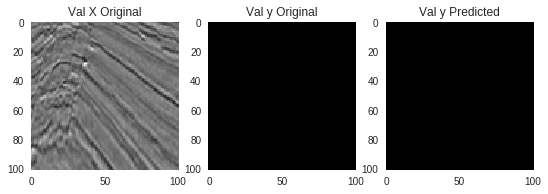

25/09/2018 12:54:24 - SaltNet - INFO - ['../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-1-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-2-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-3-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-4-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-5-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-6-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-7-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-8-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-9-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_

/content/salt_net
From https://github.com/allen-q/salt_net
   15d0cfa..c19e66f  master     -> origin/master
There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=origin/<branch> master

[master a783055] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 583 bytes | 583.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   c19e66f..a783055  master -> master
Failed to crop image to fit requirements. Use orignal image.


25/09/2018 12:58:01 - SaltNet - INFO - Train IOU: 0.6509, Acc: 0.9525, Loss: [0.0078, 0.0111, 0.019] at epoch 6


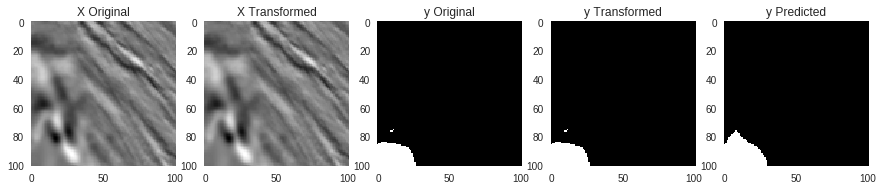

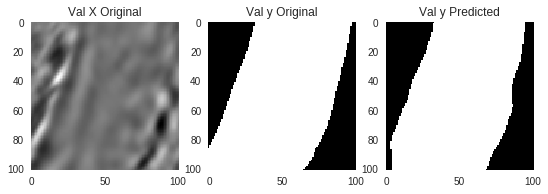

25/09/2018 12:58:16 - SaltNet - INFO - Val   IOU: 0.8010, Acc: 0.9582, Best Val IOU: 0.8094 at epoch 6
25/09/2018 12:58:16 - SaltNet - INFO - None
25/09/2018 12:58:16 - SaltNet - INFO - Epoch 7/100
25/09/2018 12:58:16 - SaltNet - INFO - --------------------
25/09/2018 13:01:34 - SaltNet - INFO - Train IOU: 0.6516, Acc: 0.9470, Loss: [0.0085, 0.0111, 0.0197] at epoch 7


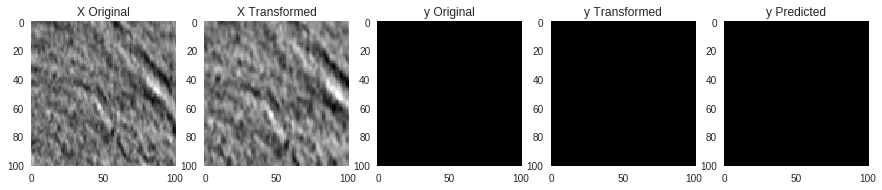

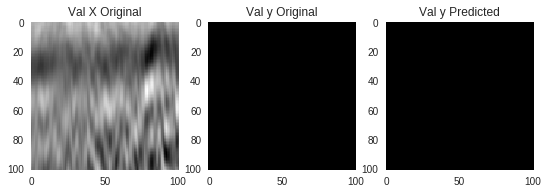

25/09/2018 13:01:52 - SaltNet - INFO - ['../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-1-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-2-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-3-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-4-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-5-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-6-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-7-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-8-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-9-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_

/content/salt_net
From https://github.com/allen-q/salt_net
   c19e66f..a783055  master     -> origin/master
There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=origin/<branch> master

[master 374388a] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 589 bytes | 589.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   a783055..374388a  master -> master


25/09/2018 13:05:28 - SaltNet - INFO - Train IOU: 0.6630, Acc: 0.9520, Loss: [0.0081, 0.0107, 0.0188] at epoch 8


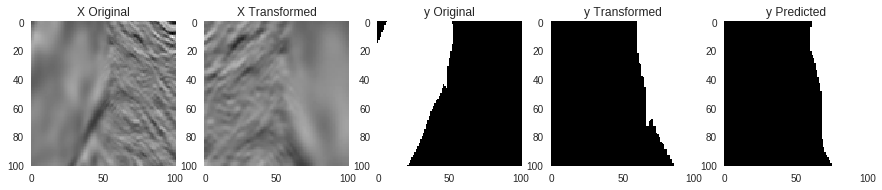

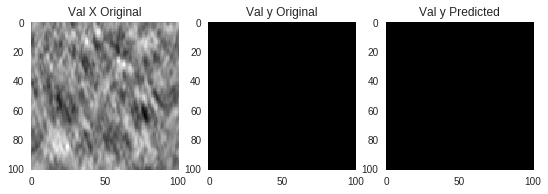

25/09/2018 13:05:43 - SaltNet - INFO - Val   IOU: 0.7964, Acc: 0.9552, Best Val IOU: 0.8096 at epoch 8
25/09/2018 13:05:43 - SaltNet - INFO - None
25/09/2018 13:05:43 - SaltNet - INFO - Epoch 9/100
25/09/2018 13:05:43 - SaltNet - INFO - --------------------
25/09/2018 13:09:02 - SaltNet - INFO - Train IOU: 0.6548, Acc: 0.9499, Loss: [0.0083, 0.0109, 0.0192] at epoch 9


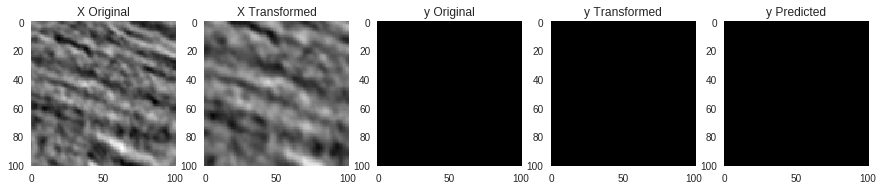

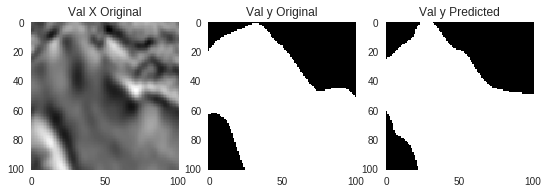

25/09/2018 13:09:17 - SaltNet - INFO - Val   IOU: 0.8080, Acc: 0.9581, Best Val IOU: 0.8096 at epoch 9
25/09/2018 13:09:17 - SaltNet - INFO - None
25/09/2018 13:09:17 - SaltNet - INFO - Epoch 10/100
25/09/2018 13:09:17 - SaltNet - INFO - --------------------
25/09/2018 13:09:17 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
From https://github.com/allen-q/salt_net
   a783055..374388a  master     -> origin/master
There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=origin/<branch> master

[master d452aa6] Pushing logs to git
 1 file changed, 11 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 563 bytes | 563.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   374388a..d452aa6  master -> master


25/09/2018 13:12:52 - SaltNet - INFO - Train IOU: 0.6576, Acc: 0.9532, Loss: [0.0076, 0.0109, 0.0185] at epoch 10


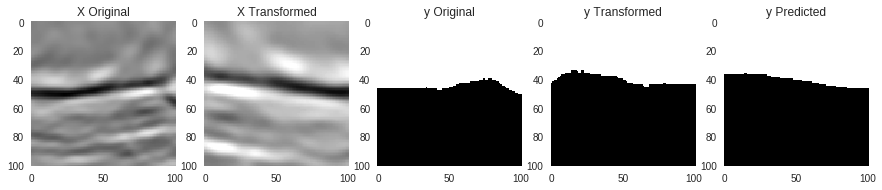

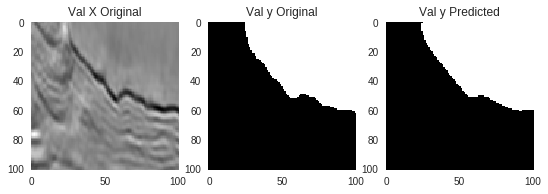

25/09/2018 13:13:07 - SaltNet - INFO - Val   IOU: 0.8051, Acc: 0.9579, Best Val IOU: 0.8096 at epoch 10
25/09/2018 13:13:07 - SaltNet - INFO - None
25/09/2018 13:13:07 - SaltNet - INFO - Epoch 11/100
25/09/2018 13:13:07 - SaltNet - INFO - --------------------
25/09/2018 13:16:26 - SaltNet - INFO - Train IOU: 0.6621, Acc: 0.9537, Loss: [0.0073, 0.0105, 0.0178] at epoch 11


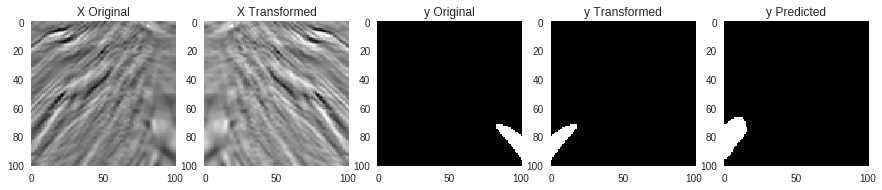

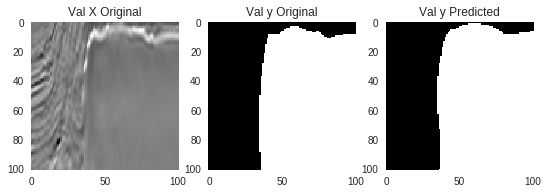

25/09/2018 13:16:44 - SaltNet - INFO - ['../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-1-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-2-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-3-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-4-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-5-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-6-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-7-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-8-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-9-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_

/content/salt_net
From https://github.com/allen-q/salt_net
   374388a..d452aa6  master     -> origin/master
There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=origin/<branch> master

[master efc6f84] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 586 bytes | 586.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   d452aa6..efc6f84  master -> master


25/09/2018 13:20:20 - SaltNet - INFO - Train IOU: 0.6622, Acc: 0.9548, Loss: [0.0078, 0.0107, 0.0185] at epoch 12


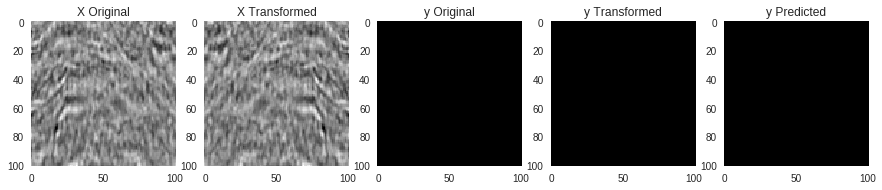

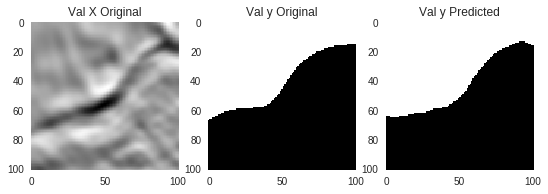

25/09/2018 13:20:36 - SaltNet - INFO - Val   IOU: 0.8118, Acc: 0.9624, Best Val IOU: 0.8153 at epoch 12
25/09/2018 13:20:36 - SaltNet - INFO - None
25/09/2018 13:20:36 - SaltNet - INFO - Epoch 13/100
25/09/2018 13:20:36 - SaltNet - INFO - --------------------
25/09/2018 13:23:54 - SaltNet - INFO - Train IOU: 0.6728, Acc: 0.9557, Loss: [0.0071, 0.0102, 0.0174] at epoch 13


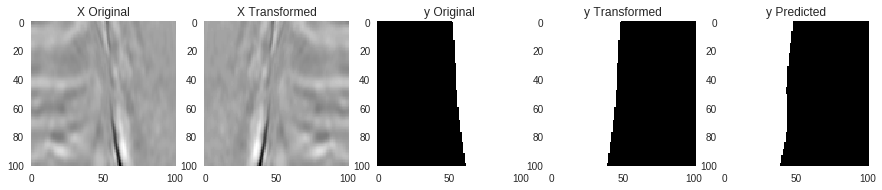

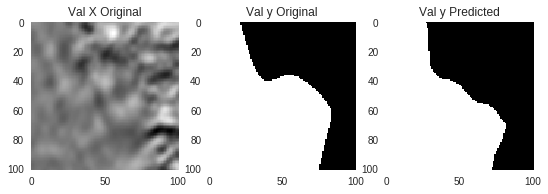

25/09/2018 13:24:10 - SaltNet - INFO - Val   IOU: 0.8139, Acc: 0.9600, Best Val IOU: 0.8153 at epoch 13
25/09/2018 13:24:10 - SaltNet - INFO - None
25/09/2018 13:24:10 - SaltNet - INFO - Epoch 14/100
25/09/2018 13:24:10 - SaltNet - INFO - --------------------
25/09/2018 13:24:10 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
From https://github.com/allen-q/salt_net
   d452aa6..efc6f84  master     -> origin/master
There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=origin/<branch> master

[master 8b49c0e] Pushing logs to git
 1 file changed, 11 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 560 bytes | 560.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   efc6f84..8b49c0e  master -> master


25/09/2018 13:27:45 - SaltNet - INFO - Train IOU: 0.6667, Acc: 0.9556, Loss: [0.0072, 0.0104, 0.0175] at epoch 14


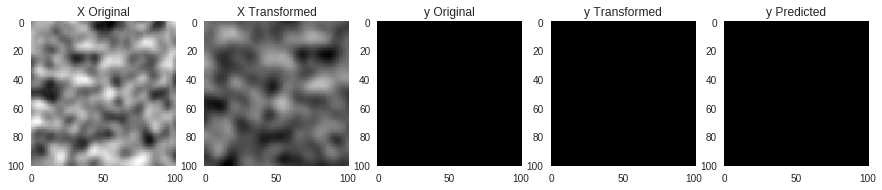

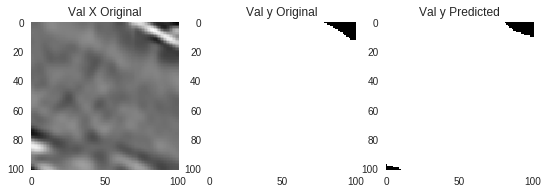

25/09/2018 13:28:00 - SaltNet - INFO - Val   IOU: 0.8080, Acc: 0.9553, Best Val IOU: 0.8153 at epoch 14
25/09/2018 13:28:00 - SaltNet - INFO - None
25/09/2018 13:28:00 - SaltNet - INFO - Epoch 15/100
25/09/2018 13:28:00 - SaltNet - INFO - --------------------
25/09/2018 13:31:18 - SaltNet - INFO - Train IOU: 0.6725, Acc: 0.9598, Loss: [0.0069, 0.0103, 0.0172] at epoch 15


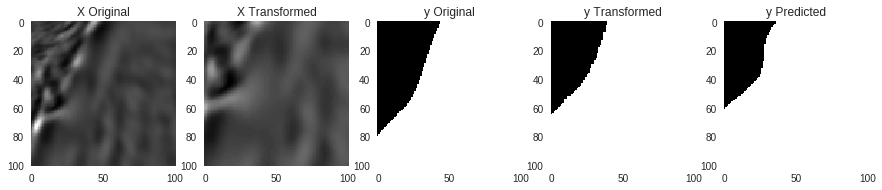

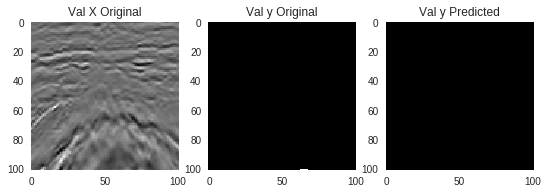

25/09/2018 13:31:34 - SaltNet - INFO - Val   IOU: 0.8130, Acc: 0.9622, Best Val IOU: 0.8153 at epoch 15
25/09/2018 13:31:34 - SaltNet - INFO - None
25/09/2018 13:31:34 - SaltNet - INFO - Epoch 16/100
25/09/2018 13:31:34 - SaltNet - INFO - --------------------
25/09/2018 13:31:34 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
From https://github.com/allen-q/salt_net
   efc6f84..8b49c0e  master     -> origin/master
There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=origin/<branch> master

[master 9e90d36] Pushing logs to git
 1 file changed, 11 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 574 bytes | 574.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   8b49c0e..9e90d36  master -> master
Failed to crop image to fit requirements. Use orignal image.


25/09/2018 13:35:09 - SaltNet - INFO - Train IOU: 0.6640, Acc: 0.9590, Loss: [0.0068, 0.0103, 0.0172] at epoch 16


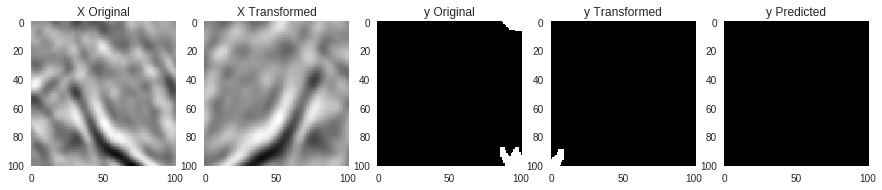

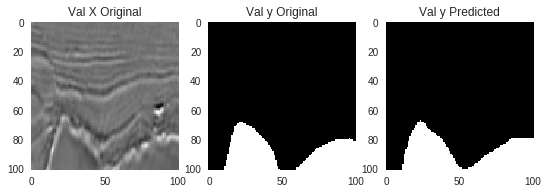

25/09/2018 13:35:24 - SaltNet - INFO - Val   IOU: 0.8141, Acc: 0.9642, Best Val IOU: 0.8153 at epoch 16
25/09/2018 13:35:24 - SaltNet - INFO - None
25/09/2018 13:35:24 - SaltNet - INFO - Epoch 17/100
25/09/2018 13:35:24 - SaltNet - INFO - --------------------
25/09/2018 13:38:43 - SaltNet - INFO - Train IOU: 0.6672, Acc: 0.9591, Loss: [0.0069, 0.0103, 0.0172] at epoch 17


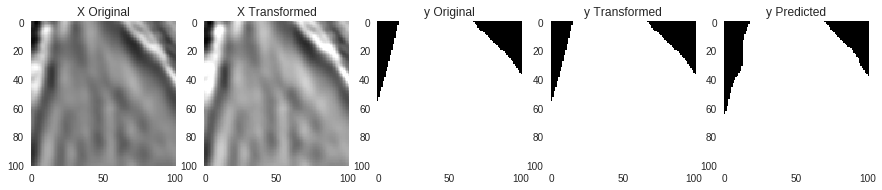

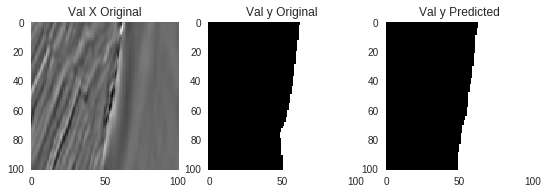

25/09/2018 13:38:58 - SaltNet - INFO - Val   IOU: 0.8121, Acc: 0.9652, Best Val IOU: 0.8153 at epoch 17
25/09/2018 13:38:58 - SaltNet - INFO - None
25/09/2018 13:38:58 - SaltNet - INFO - Epoch 18/100
25/09/2018 13:38:58 - SaltNet - INFO - --------------------
25/09/2018 13:38:58 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
From https://github.com/allen-q/salt_net
   8b49c0e..9e90d36  master     -> origin/master
There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=origin/<branch> master

[master 7302011] Pushing logs to git
 1 file changed, 11 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 539 bytes | 539.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   9e90d36..7302011  master -> master


25/09/2018 13:42:35 - SaltNet - INFO - Train IOU: 0.6791, Acc: 0.9598, Loss: [0.0067, 0.01, 0.0166] at epoch 18


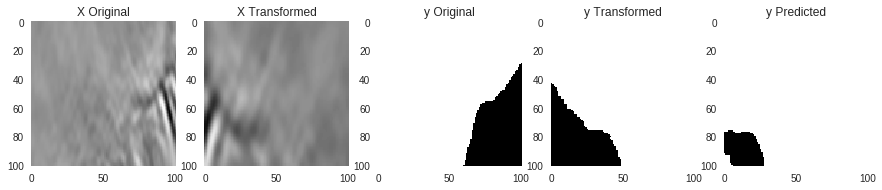

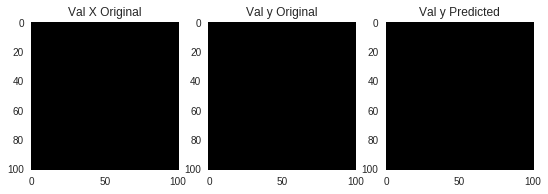

25/09/2018 13:42:53 - SaltNet - INFO - ['../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-1-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-2-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-3-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-4-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-5-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-6-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-7-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-8-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_2018_09_25_22_01_28.ckp-chunk-9-Of-10', '../salt_net/Unet_res34_weight_decay_over_sample_finetune15_

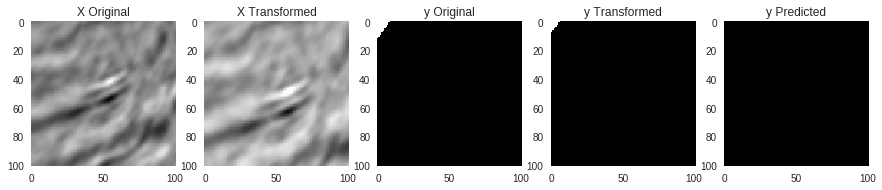

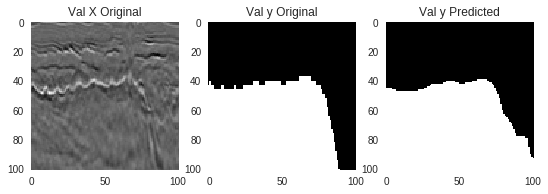

25/09/2018 13:46:27 - SaltNet - INFO - Val   IOU: 0.8117, Acc: 0.9603, Best Val IOU: 0.8165 at epoch 19
25/09/2018 13:46:27 - SaltNet - INFO - None
25/09/2018 13:46:27 - SaltNet - INFO - Epoch 20/100
25/09/2018 13:46:27 - SaltNet - INFO - --------------------
25/09/2018 13:46:27 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
From https://github.com/allen-q/salt_net
   9e90d36..7302011  master     -> origin/master
There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=origin/<branch> master

[master 24f9f75] Pushing logs to git
 1 file changed, 13 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 587 bytes | 587.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   7302011..24f9f75  master -> master


25/09/2018 13:50:02 - SaltNet - INFO - Train IOU: 0.6775, Acc: 0.9585, Loss: [0.0066, 0.0098, 0.0163] at epoch 20


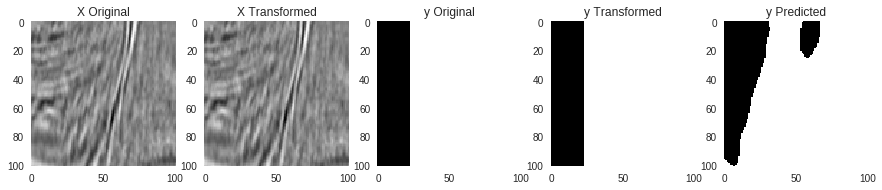

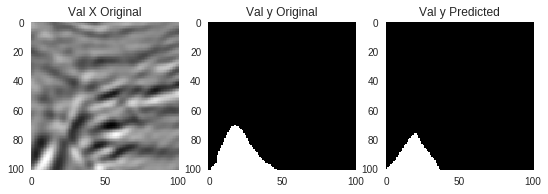

25/09/2018 13:50:17 - SaltNet - INFO - Val   IOU: 0.8098, Acc: 0.9590, Best Val IOU: 0.8165 at epoch 20
25/09/2018 13:50:17 - SaltNet - INFO - Skip pushing model to git as there's no improvement
25/09/2018 13:50:17 - SaltNet - INFO - None
25/09/2018 13:50:17 - SaltNet - INFO - Epoch 21/100
25/09/2018 13:50:17 - SaltNet - INFO - --------------------
25/09/2018 13:53:36 - SaltNet - INFO - Train IOU: 0.6858, Acc: 0.9607, Loss: [0.0063, 0.0095, 0.0158] at epoch 21


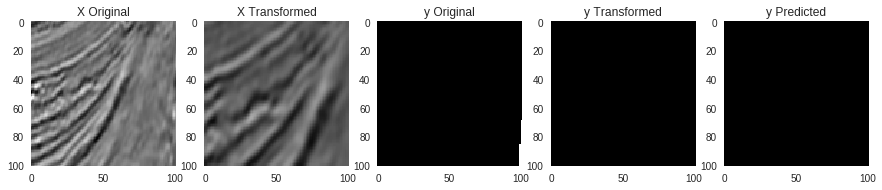

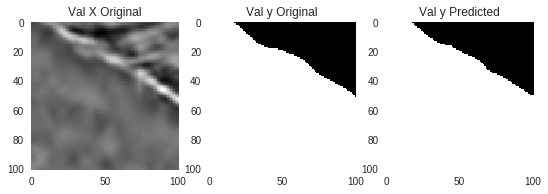

25/09/2018 13:53:52 - SaltNet - INFO - Val   IOU: 0.8086, Acc: 0.9591, Best Val IOU: 0.8165 at epoch 21
25/09/2018 13:53:52 - SaltNet - INFO - None
25/09/2018 13:53:52 - SaltNet - INFO - Epoch 22/100
25/09/2018 13:53:52 - SaltNet - INFO - --------------------
25/09/2018 13:53:52 - SaltNet - INFO - Pushing logs to git.


/content/salt_net
From https://github.com/allen-q/salt_net
   7302011..24f9f75  master     -> origin/master
There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=origin/<branch> master

[master 370dde1] Pushing logs to git
 1 file changed, 12 insertions(+)
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 609 bytes | 609.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/allen-q/salt_net.git
   24f9f75..370dde1  master -> master


25/09/2018 13:57:29 - SaltNet - INFO - Train IOU: 0.6743, Acc: 0.9589, Loss: [0.0064, 0.0097, 0.0161] at epoch 22


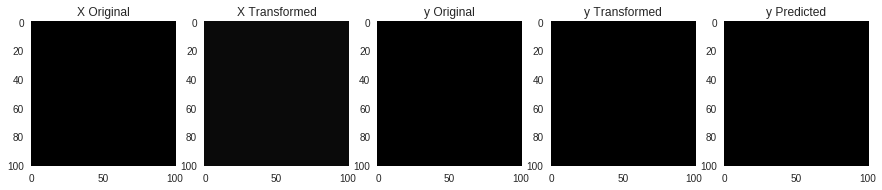

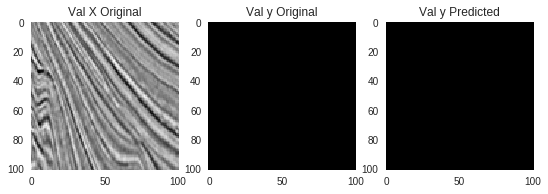

25/09/2018 13:57:45 - SaltNet - INFO - Val   IOU: 0.8118, Acc: 0.9585, Best Val IOU: 0.8165 at epoch 22
25/09/2018 13:57:45 - SaltNet - INFO - None
25/09/2018 13:57:45 - SaltNet - INFO - Epoch 23/100
25/09/2018 13:57:45 - SaltNet - INFO - --------------------


In [0]:
train_model(saltnet, dataloaders, (loss_focal, loss_lovasz_hinge), (1, 0.02), optimizer, scheduler, train_params, all_data)

In [284]:
0.8**20

0.011529215046068483

## Load Trained Model

In [0]:
loaded_model = UResNet(pretrained=False)

In [0]:
ls

In [0]:
cd ../salt_net

In [0]:
model_file_suffix = "Unet_res34_bce_lovasz_loss_se_new_aug_finetuen1_2018_09_21_09_41_48.ckp"
model_state_dict = torch.load(join_files(model_file_suffix, '.', returnFileObject=True, removeChunks=False))
loaded_model.load_state_dict(model_state_dict['model'])

In [0]:
loaded_model = saltnet

### Make Predictions on validation set

### Set model to evaluation mode

In [0]:
loaded_model.eval()
assert loaded_model.training == False

In [0]:
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img, out_size=128), batch_size=16)

In [0]:
if torch.cuda.is_available():
    loaded_model.cuda()

### Eval model on Val data set

In [0]:
y_val_pred = []

with torch.no_grad():
    for X_val_batch, y_val_batch, depth_val_batch, X_val_id_batch in val_dataLoader:
        y_val_pred.append(loaded_model(X_val_batch))
y_val_pred = torch.cat(y_val_pred)

In [0]:
p = Pipeline_Salt()
p.flip_left_right(probability=1)
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img, out_size=128, out_ch=1,
                           transform=p.torch_transform()), batch_size=16)
y_val_pred_flip = []

with torch.no_grad():
    for X_val_batch, y_val_batch, depth_val_batch, X_val_id_batch in val_dataLoader:
        y_val_pred_flip.append(loaded_model(X_val_batch))
y_val_pred_flip = torch.cat(y_val_pred_flip)
y_val_pred_flip = torch.flip(y_val_pred_flip,[2])

#### merge normal pred and hflip pred

In [0]:
y_val_pred_ens = torch.where(y_val_pred.abs() > y_val_pred_flip.abs(), y_val_pred, y_val_pred_flip)

#### Check normal pred IOU

In [0]:
y_val_pred_adj = adjust_predictions(0, X_val, y_val_pred.gt(0), y_val.squeeze())

#### Check TTA pred IOU

In [0]:
y_val_pred_adj = adjust_predictions(0, X_val, y_val_pred_ens.gt(0), y_val.squeeze())

### Find best mask cutoff

In [0]:
results=[]
for cut_off in np.r_[-0.1:0.1:50j]:
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(0, X_val, y_val_pred_ens.gt(cut_off), y_val.squeeze()), y_val.squeeze()))

In [0]:
MASK_CUTOFF = np.r_[-0.1:0.1:50j][np.argmax(results)]

In [0]:
print(f'MASK_CUTOFF: {MASK_CUTOFF}')

#### Find best ZERO_MASK_CUTOFF

In [0]:
results=[]
for cut_off in range(0, 300, 10):
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(cut_off, X_val, y_val_pred_ens.gt(MASK_CUTOFF), y_val.squeeze()), y_val.squeeze()))

In [0]:
ZERO_MASK_CUTOFF = range(0, 300, 10)[np.argmax(results)]

In [0]:
print(f'ZERO_MASK_CUTOFF: {ZERO_MASK_CUTOFF}')

In [0]:
y_val_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_val, y_val_pred_ens.gt(MASK_CUTOFF), y_val.squeeze())

### View a few val images with predictions

In [0]:
for i in range(10):
    rand_id = np.random.choice(X_val_id_batch)
    print(f'Image ID: {rand_id}')
    val_img = X_val[rand_id]/255
    val_mask = y_val[rand_id]
    val_mask_pred = y_val_pred_ens.ge(MASK_CUTOFF)[rand_id]
    plot_img_mask_pred([val_img, val_mask, val_mask_pred], range(3), img_per_line=3)

### Eval model on Train data set

In [0]:
train_dataLoader = DataLoader(SaltDataset(X_train, y_train, depth_train, X_train_mean_img, out_size=128), batch_size=32)
y_train_pred = []

with torch.no_grad():
    for X_train_batch, y_train_batch, depth_train_batch, X_train_id_batch in train_dataLoader:
        y_train_pred.append(loaded_model(X_train_batch))
y_train_pred = torch.cat(y_train_pred)

In [0]:
p = Pipeline_Salt()
p.flip_left_right(probability=1)
train_dataLoader = DataLoader(SaltDataset(X_train, y_train, depth_train, X_train_mean_img, out_size=128, out_ch=1,
                           transform=p.torch_transform()), batch_size=32)
y_train_pred_flip = []

with torch.no_grad():
    for X_train_batch, y_train_batch, depth_train_batch, X_train_id_batch in train_dataLoader:
        y_train_pred_flip.append(loaded_model(X_train_batch))
y_train_pred_flip = torch.cat(y_train_pred_flip)
y_train_pred_flip = torch.flip(y_train_pred_flip,[2])

#### merge normal pred and hflip pred

In [0]:
y_train_pred_ens = torch.where(y_train_pred.abs() > y_train_pred_flip.abs(), y_train_pred, y_train_pred_flip)

#### Check normal pred IOU

In [0]:
y_train_pred_adj = adjust_predictions(0, X_train, y_train_pred.gt(0), y_train.squeeze())

In [0]:
loaded_model = saltnet
train_dataLoader = DataLoader(SaltDataset(X_train, y_train, depth_train, X_train_mean_img, out_size=128), batch_size=32)
y_train_pred = []

with torch.no_grad():
    for X_train_batch, y_train_batch, depth_train_batch, X_train_id_batch in train_dataLoader:
        y_train_pred.append(loaded_model(X_train_batch))
y_train_pred = torch.cat(y_train_pred)

In [0]:
train_data_weight = calc_raw_iou( y_train_pred.gt(0), y_train.squeeze())

In [0]:
train_data_weight = (1/np.clip(train_data_weight, 0.5,1)**3)

In [0]:
#train_data_weight = np.where(train_data_weight<1.1, 0.5, train_data_weight)

(array([2707.,  142.,   68.,   31.,   20.,   20.,   12.,    6.,    3.,
         191.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <a list of 10 Patch objects>)

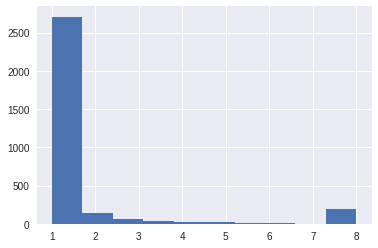

In [274]:
plt.hist(train_data_weight)

#### Check TTA pred IOU

In [0]:
y_train_pred_adj = adjust_predictions(0, X_train, y_train_pred_ens.gt(0), y_train.squeeze())

### Find best mask cutoff

In [0]:
results=[]
for cut_off in np.r_[-0.2:0.2:50j]:
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(0, X_train, y_train_pred_ens.gt(cut_off), y_train.squeeze()), y_train.squeeze()))

In [0]:
np.r_[-0.2:0.2:50j][np.argmax(results)]

In [0]:
MASK_CUTOFF = np.r_[-0.1:0.1:50j][np.argmax(results)]

In [0]:
MASK_CUTOFF = 0

In [0]:
print(f'MASK_CUTOFF: {MASK_CUTOFF}')

#### Find best ZERO_MASK_CUTOFF

In [0]:
results=[]
for cut_off in range(0, 300, 10):
  print(cut_off)
  results.append(calc_mean_iou(adjust_predictions(cut_off, X_train, y_train_pred_ens.gt(MASK_CUTOFF), y_train.squeeze()), y_train.squeeze()))

In [0]:
ZERO_MASK_CUTOFF = range(0, 300, 10)[np.argmax(results)]

In [0]:
print(f'ZERO_MASK_CUTOFF: {ZERO_MASK_CUTOFF}')

In [0]:
y_val_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_val, y_val_pred_ens.gt(MASK_CUTOFF), y_val.squeeze())

In [0]:
y_train_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_train, y_train_pred_ens.gt(MASK_CUTOFF), y_train.squeeze())

In [0]:
for i in range(10):
    rand_id = np.random.choice(X_train_id_batch)
    print(f'Image ID: {rand_id}')
    img = X_train[rand_id]/255
    mask = y_train[rand_id]
    mask_pred = y_train_pred.ge(MASK_CUTOFF)[rand_id]
    plot_img_mask_pred([img, mask, mask_pred], range(3), img_per_line=3)

## Make predictions on test set using TTA

In [0]:
import numpy as np

### Predict using original image

In [0]:
test_dataLoader = DataLoader(SaltDataset(X_test, np.zeros_like(X_test), depth_test, X_train_mean_img, out_size=128), batch_size=32)

In [0]:
y_test_pred_raw = []
with torch.no_grad():
    for X_test_batch, y_test_batch, depth_test_batch, X_test_id_batch in test_dataLoader:
        y_test_pred_raw.append(loaded_model(X_test_batch))
y_test_pred = torch.cat(y_test_pred_raw)

### Predict using flipped images

In [0]:
p = Pipeline_Salt()
p.flip_left_right(probability=1)
test_dataLoader = DataLoader(SaltDataset(X_test, np.zeros_like(X_test), depth_test, X_train_mean_img, out_size=128, out_ch=1,
                           transform=p.torch_transform()), batch_size=32)
y_test_pred_flip = []

with torch.no_grad():
    for X_test_batch, y_test_batch, depth_test_batch, X_test_id_batch in test_dataLoader:
        y_test_pred_flip.append(loaded_model(X_test_batch))
y_test_pred_flip = torch.cat(y_test_pred_flip)
y_test_pred_flip = torch.flip(y_test_pred_flip,[2])

### Combine non-flip and flip predictions

In [0]:
y_test_pred = torch.where(y_test_pred.abs() > y_test_pred_flip.abs(), y_test_pred, y_test_pred_flip)

### Adjust predictions

In [0]:
MASK_CUTOFF = 0
ZERO_MASK_CUTOFF = 0

In [0]:
print(f'MASK_CUTOFF:{MASK_CUTOFF}, ZERO_MASK_CUTOFF:{ZERO_MASK_CUTOFF}')

In [0]:
y_test_pred_adj = adjust_predictions(ZERO_MASK_CUTOFF, X_test, y_test_pred.gt(MASK_CUTOFF))


### Show segmentation masks for a few images

In [0]:
for i in range(10):
    rand_id = np.random.choice(X_test_id_batch)
    print(f'Image ID: {rand_id}')
    img = X_test[rand_id]/255
    mask_pred = y_test_pred.ge(0.5)[rand_id]
    plot_img_mask_pred([img, mask_pred], range(2))

### Prepare for submission

In [0]:
y_test_pred_rle = rle_encoder3d(y_test_pred_adj)

In [0]:
y_test_pred_adj.shape

In [0]:
df_test_rle = pd.DataFrame(index=misc_data['np_test_ids'], data=y_test_pred_rle).reset_index()

In [0]:
df_test_rle.columns = ['id', 'rle_mask']

In [0]:
df_test_rle[df_test_rle.rle_mask==''].shape

In [0]:
df_test_rle.shape

In [0]:
df_test_rle.to_csv(f'submission_{get_current_time_as_fname()}.csv', index=False)

In [0]:
ls

In [0]:
from google.colab import files


In [0]:
files.download('submission_2018_09_21_13_11_16.csv') 